In [77]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import numpy as np
import torch
import matplotlib.pyplot as plt

# nltk.download('punkt')
# nltk.download("stopwords")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [2]:
# import requests

# link = "https://www.4icu.org/us/"
# f = requests.get(link)
# # print(f.text)

# # print(f.text)

# import re

# university_list = re.findall("<td><a href=\S+>(\D+)</a>", f.text)
# for x in range(len(university_list)):
#     curr = university_list[x]
#     if curr.lower() == "columbia university in the city of new york":
#         university_list[x] = curr[:19] 
#     if "&amp" in curr:
#         university_list[x].replace("&amp;", " ")
#         # and_index = curr.index("&")
#         # university_list[x] = curr[0:and_index] + " " + curr[and_index+5:]
#     if "The" in curr:
#         university_list[x] = curr[3:]
#     if "," in curr:
#         university_list[x].replace(",", "")

# print(len(university_list))

# top_400 = university_list[0:400]



1766


In [2]:
import requests

# link = "https://www.collegevine.com/schools/hub/overall/sheet"

link = "https://www.collegevine.com/schools/hub/data/static"

# avoid printing f.text; Large file
f = requests.get(link)


# "majorsCipCodes":["11.0701","14.0501","14.1001","14.1301","14.1901","16.0102","16.0104","16.0201",
# "16.0301","16.0302","16.0303","16.04","16.0402","16.0407","16.0408","16.0501","16.0502","16.0506",
# "16.0599","16.0701","16.09","16.0901","16.0902","16.0904","16.0905","16.1101","16.1102","16.12",
# "16.1203","16.1299","16.1301","16.1402","16.1501","23.0101","24.0101","24.0103","26.0101","26.0202",
# "26.0404","26.0406","26.0599","26.1303","26.1503","27.0101","27.0301","27.0501","3.0103","30.1301",
# "30.1701","30.1801","38.0101","38.0201","39.0601","40.0202","40.0203","40.0299","40.0501","40.0508",
# "40.0599","40.0601","40.0801","42.0101","42.2701","42.2704","45.0101","45.0201","45.0301","45.0601",
# "45.0603","45.1001","45.1101","5.0104","5.0105","5.0108","5.011","5.0112","5.0201","5.0207","5.0208",
# "5.0209","5.0299","50.0101","50.0501","50.0601","50.0702","50.0703","50.0901","51.221","54.0101",
# "54.0103","54.0104","54.0199"],"name":"Harvard University","numFreshmen"

# "majorsCipCodes":["11.0103","11.0201","11.0701","11.0801","11.1099","11.9999","13.1001","13.1203",
# "13.121","13.1302","13.1303","13.1305","13.1306","13.1307","13.1308","13.1311","13.1312","13.1314",
# "13.1316","13.1318","13.1322","13.1325","13.133","14.0701","14.0801","14.1001","14.1801","14.1901",
# "14.3501","15.0201","15.0303","15.0702","15.0805","15.1201","16.0102","16.0901","16.0902","16.0905",
# "19.0707","23.0101","23.1302","23.1303","23.1304","24.0101","24.0102","26.0101","26.0202","27.0101",
# "3.0104","30.1101","31.0501","31.0505","38.0101","38.0201","40.0201","40.0501","40.0601","40.0699",
# "40.0801","42.0101","43.0104","43.0106","44","44.0701","45.0101","45.0201","45.0601","45.0701","45.0799",
# "45.0901","45.1001","45.1101","5.0101","5.0102","5.0201","50.0399","50.0501","50.0702","50.0703","50.0901",
# "50.0902","50.0903","50.0904","50.1001","51","51.0001","51.0602","51.0701","51.0702","51.0899","51.0908",
# "51.1005","51.1504","51.2201","51.3101","51.3801","51.9999","52.0201","52.0205","52.0301","52.0304","52.0601",
# "52.0801","52.0901","52.1001","52.1002","52.1101","52.1201","52.1206","52.1302","52.1399","52.1401","52.1403",
# "52.1902","54.0101","9.0401","9.0701","9.0903","9.0906"],"name":"Youngstown State University","numFreshmen"

import re

# university_list = re.findall("\"name\":\"([^\"]+)\",\"numFreshmen\"", f.text)
university_list = re.findall("\"rankings\":.+?\"bucket\":\"(\d*)\",\"key\":\"overall\".+?\"slug\":\"(.+?)\"", f.text)

# \"slug\":\"(.+?)\"
# print(university_list[0:10])

# "\"rankings\":.+?\"order\":(\d*)(?=.+?\"key\"=\"overall\")\"slug\":\"(.+?)\""


# # \"majorsCipCodes\".+\"
# # \"numFreshmen\"

# # ([^,\"])

# # for x in range(len(university_list)):
# #     curr = university_list[x]

print(university_list[0])



('305', 'abilene-christian-university')


In [118]:
university_list = sorted(university_list, key = lambda pair: pair[0])

gap = 0

for x in range(len(university_list)):
    university_list[x] = [int(university_list[x][0]), university_list[x][1]]
    if x+1 != int(university_list[x][0]) - gap:
        gap += 1
        print(university_list[x-1:x+1])

print(len(sorted(university_list, key = lambda pair: pair[0])))

top_400 = university_list[0:400]

# print(len(university_list))

# top_400 = university_list[0:400]

# print(top_400)

[[287, 'bryant-university'], [289, 'milwaukee-school-of-engineering-msoe']]
[[403, 'ohio-wesleyan-university'], [405, 'brigham-young-university-hawaii']]
[[647, 'university-of-indianapolis'], [649, 'franklin-college']]
[[676, 'st-edward-s-university'], [678, 'high-point-university']]
[[799, 'university-of-nebraska-omaha-uno'], [801, 'university-of-toledo']]
[[852, 'rocky-mountain-college-rmc'], [854, 'hardin-simmons-university']]
[[867, 'johnson-c-smith-university'], [869, 'spring-arbor-university']]
[[1053, 'tabor-college'], [1055, 'wells-college']]
[[1064, 'hope-international-university'], [1066, 'university-of-northwestern-st-paul']]
[[1191, 'concordia-college-new-york'], [1193, 'methodist-university']]
[[1264, 'notre-dame-de-namur-university'], [1266, 'felician-university']]
[[1349, 'dakota-state-university'], [1351, 'southern-university-at-new-orleans']]
1506


In [6]:
# testtext = "\"majorsCipCodes\":[\"11.0701\", \"11.0701\"],\"name\":\"Harvard University\",\"numFreshmen\""

# testlist = re.findall("\"majorsCipCodes\".+\"name\":\"(.*)\",\"numFreshmen\"", testtext)

# print(testlist)

['Harvard University']


In [4]:
# get links for all schools

college_links = []

for school in top_400:
    name = school[1]
    college_links.append("https://www.collegevine.com/schools/" 
                            + name.replace(" ", "-") 
                            +  "/essay-prompts")

print(college_links[0])

https://www.collegevine.com/schools/stanford-university/essay-prompts


In [9]:
# test_link = "https://www.collegevine.com/schools/harvard-university/essay-prompts"

# f = requests.get(test_link)
# # print(f.text)

# titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
# prompts = re.findall("<p>(.+?)</p>", f.text)[0:-7]
# # titles = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)[0:-1]
# print(prompts)

# select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)
# print(select_prompts)


# if prompts == []:
#     potential_issues.append(link)

# if len(titles) != len(prompts)-7:
#     print(len(titles))
#     print(len(prompts))
#     print(link)

In [10]:
# access links
# allprompts = []

# potential_issues = []
# shift = 0

# for link in college_links:
#     f = requests.get(link)

#     titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
#     prompts = re.findall("<p>(.+?)</p>", f.text)
#     # print(titles)
#     if titles[-1] == "Common App Personal Essay":
#         titles = titles[:-1]
#         prompts = prompts[:-8]
    
#     if "Select-A-Prompt Short Response" in titles:
#         select_prompt_ind = titles.index("Select-A-Prompt Short Response")
#         del titles[select_prompt_ind]
#         del prompts[select_prompt_ind]

#         select_prompts = re.findall("<h5>(.+?)</h5>", f.text)
#         for x in select_prompts:
#             titles.append("Select-A-Prompt")
#             prompts.append(x)



#     allprompts.append(prompts)

#     if prompts == []:
#         potential_issues.append(link)

#     if len(titles) != len(prompts):
#         print(link)

# print(potential_issues)

# print(college_links[333])

# temp_f = requests.get(college_links[323])

# prompts = re.findall("<p>(.+)</p>", temp_f.text)
# print(prompts)


In [36]:
# obtain word bag

def get_bag(docs, word_list):
    out_list = []

    for doc in docs:
        stop_words = set(stopwords.words("english") + ["etc", "'s", ""])
        filtered_list = []

        seperated_words = word_tokenize(doc[1])

        for word in seperated_words:
            # currently deciding to filter out punctuation
            if word[-1] in [".", ",", ";", ":", "?", "!", "*", "’", "–"]:
                word = word[:-1]
            if word not in stop_words:
                # currently ignoring capitalization
                filtered_list.append(word.lower())
        
        # filtered_list = [word for word in doc[1].split() if word not in stop_words]
        tagged_list = nltk.pos_tag(filtered_list)
        
        lemmatizer = WordNetLemmatizer()
        lemmatized_list = []

        for word in tagged_list:
            pos = ""
            # print(word[1][0])
            if word[1][0] == "J":
                pos = "a"
            elif word[1][0] == "N":
                pos = "n"
            elif word[1][0] == "V":
                pos = "v"
            elif word[1][0] == "R":
                pos = "r"
            else:
                # print("uh oh")
                lemmatized_list.append(word[0])
                continue
            
            lemmatized_list.append(lemmatizer.lemmatize(word[0], pos=pos))

        word_list += lemmatized_list
        out_list.append(lemmatized_list)
        
    return out_list, word_list

In [25]:
# nlp processing
def process(docs, word_dictionary):
    print("e")
    for doc in docs:
        print(doc)
        curr_vector = []
        for word in doc.split():
            if word in word_dictionary.keys():
                word_dictionary[word] += 1
    


In [38]:
# access links and create general word bag
allprompts = {}

potential_issues = []
shift = 0
prompts = []
has_common_app = False
word_list = []

for link_index in range(len(college_links)):
    has_common_app = False
    link = college_links[link_index]
    f = requests.get(link)

    noprompts = re.search("<h2>", f.text)

    if not bool(noprompts):
        prompts = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)
        select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)

        if prompts == []:
            potential_issues.append(link)
            continue

        if prompts[-1][0] == "Common App Personal Essay":
            has_common_app = True
            prompts = prompts[:-1]
            select_prompts = select_prompts[:-7]

        if select_prompts != []:
            i = 0
            while i < len(prompts):
                # print(len(prompts[x]))
                if "Select-A-Prompt" in prompts[i][0]:
                    del prompts[i]
                else:
                    i += 1

            if has_common_app:
                for x in select_prompts:
                    prompts.append(("Select-A-Prompt", x))

        # checks again, but now for schools with only common app essay
        if prompts == []:
            continue

        prompts, word_list = get_bag(prompts, word_list)
        
        school_rank = top_400[link_index][0]
        allprompts[school_rank] = prompts

In [37]:
# single case testing

has_common_app = False
link = "https://www.collegevine.com/schools/stanford-university/essay-prompts"
f = requests.get(link)

noprompts = re.search("<h2>", f.text)
allprompts = {}
word_list = []

for link_index in range(1,2):
    if not bool(noprompts):
        prompts = re.findall("<h3 class='mt-2'>(.+?)</h3>[\S\s]+?<p>(.+?)</p>", f.text)
        select_prompts = re.findall("</h5>\s<p>\s<p>(.+?)</p>", f.text)

        if prompts == []:
            potential_issues.append(link)
            break

        if prompts[-1][0] == "Common App Personal Essay":
            has_common_app = True
            prompts = prompts[:-1]
            select_prompts = select_prompts[:-7]

        if select_prompts != []:
            i = 0
            while i < len(prompts):
                # print(len(prompts[x]))
                if "Select-A-Prompt" in prompts[i][0]:
                    del prompts[i]
                else:
                    i += 1

            if has_common_app:
                for x in select_prompts:
                    prompts.append(("Select-A-Prompt", x))

        word_list = get_bag(prompts, word_list)

        school_rank = top_400[link_index][0]
        allprompts[school_rank] = prompts


print(word_list[0:100])

([['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning'], ['virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommate', 'reveals', 'something', 'help', 'roommate', 'us', 'get', 'know', 'good'], ['tell', 'us', 'something', 'meaningful'], ['what', 'significant', 'challenge', 'society', 'face', 'today'], ['how', 'spend', 'last', 'two', 'summer'], ['what', 'historical', 'moment', 'event', 'wish', 'could', 'witness'], ['briefly', 'elaborate', 'one', 'extracurricular', 'activity', 'job', 'hold', 'responsibility', 'family'], ['name', 'one', 'thing', 'look', 'forward', 'experience', 'stanford']], ['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning', 'virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommat

In [9]:
len(potential_issues)

print(potential_issues)

[]


In [34]:
print(allprompts.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 46, 47, 49, 51, 52, 53, 56, 57, 58, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 80, 81, 82, 84, 86, 87, 88, 89, 90, 94, 96, 97, 98, 102, 103, 104, 108, 109, 110, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 130, 131, 133, 134, 135, 137, 138, 139, 141, 143, 145, 147, 148, 154, 157, 158, 159, 162, 165, 170, 173, 174, 177, 178, 179, 180, 183, 184, 186, 187, 191, 194, 196, 198, 199, 201, 205, 206, 207, 209, 211, 213, 215, 216, 217, 220, 226, 227, 229, 231, 232, 234, 237, 238, 241, 244, 247, 248, 249, 250, 251, 252, 254, 255, 256, 257, 261, 262, 265, 266, 267, 268, 274, 277, 281, 282, 283, 284, 285, 294, 295, 302, 303, 304, 306, 307, 314, 315, 317, 319, 320, 321, 322, 329, 330, 332, 334, 340, 341, 343, 346, 348, 349, 352, 356, 363, 365, 367, 368, 369, 370, 371, 377, 389, 392, 393, 397, 398])


In [39]:
print(len(word_list), len(set(word_list)))

print(word_list[0:100])

12758 2458
['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning', 'virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommate', 'reveals', 'something', 'help', 'roommate', 'us', 'get', 'know', 'good', 'tell', 'us', 'something', 'meaningful', 'what', 'significant', 'challenge', 'society', 'face', 'today', 'how', 'spend', 'last', 'two', 'summer', 'what', 'historical', 'moment', 'event', 'wish', 'could', 'witness', 'briefly', 'elaborate', 'one', 'extracurricular', 'activity', 'job', 'hold', 'responsibility', 'family', 'name', 'one', 'thing', 'look', 'forward', 'experience', 'stanford', 'your', 'intellectual', 'life', 'may', 'extend', 'beyond', 'academic', 'requirement', 'particular', 'school', 'please', 'use', 'space', 'list', 'additional', 'intellectual', 'activity', 'mention', 'detail', 'elsewhere', 'application', 'these', 'could', 'include', '

In [40]:
print(allprompts[1])

[['the', 'stanford', 'community', 'deeply', 'curious', 'driven', 'learn', 'classroom', 'reflect', 'idea', 'experience', 'make', 'genuinely', 'excited', 'learning'], ['virtually', 'stanford', 'undergraduate', 'live', 'campus', 'write', 'note', 'future', 'roommate', 'reveals', 'something', 'help', 'roommate', 'us', 'get', 'know', 'good'], ['tell', 'us', 'something', 'meaningful'], ['what', 'significant', 'challenge', 'society', 'face', 'today'], ['how', 'spend', 'last', 'two', 'summer'], ['what', 'historical', 'moment', 'event', 'wish', 'could', 'witness'], ['briefly', 'elaborate', 'one', 'extracurricular', 'activity', 'job', 'hold', 'responsibility', 'family'], ['name', 'one', 'thing', 'look', 'forward', 'experience', 'stanford']]


In [10]:
for i in range(len(top_400)):
    if i == 384:
        print(top_400[i])

[386, 'birmingham-southern-college-bsc']


In [11]:
alltitles = []

for link in college_links:
    f = requests.get(link)

    titles = re.findall("<h3 class='mt-2'>(.+?)</h3>", f.text)
    alltitles += titles

alltitles = set(alltitles)

print(len(alltitles))


230


In [ ]:
print(alltitles)

In [45]:
# turn prompts into vectors

for rank, prompts in allprompts.items():
    curr_freq = dict(zip(word_list, [0 for x in range(len(word_list))]))
    for prompt_ind in range(len(prompts)):
        for word in prompts[prompt_ind]:
            curr_freq[word] += 1
        allprompts[rank][prompt_ind] = list(curr_freq.values())

In [96]:
# print(allprompts[17])
prompt_matrix = []

for prompts in allprompts.values():
    for prompt in prompts:
        prompt_matrix.append(prompt)

prompt_tensor = torch.tensor(prompt_matrix ,dtype=torch.float32)

print(prompt_tensor.shape)

torch.manual_seed(333)
U, S, V = torch.pca_lowrank(prompt_tensor, q=None, center=True, niter=3)

pca_axes = torch.matmul(prompt_tensor, V[:, :7])

torch.Size([728, 2458])


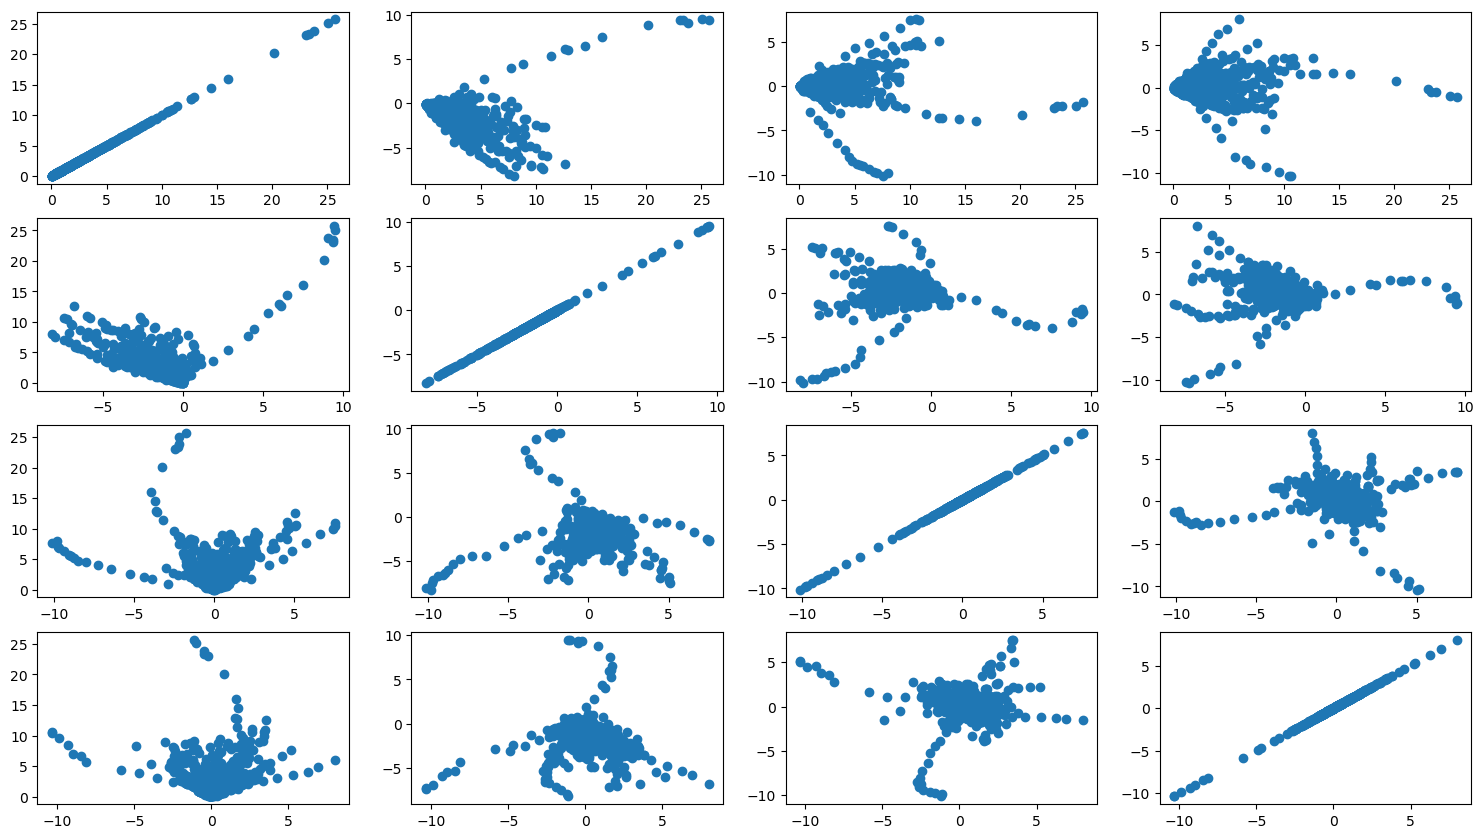

In [117]:
# print(pca_axes[...,0])
# print(max(pca_axes[:,0]))


# combo plot
num_comps = 4

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(0, num_comps):
    for j in range(0, num_comps):
        axs[i][j].scatter(pca_axes[:,i], pca_axes[:,j])

# interesting note: almost all the plots have a central clump and then one or more very pronounced arms
# need to consider whether PCA is meaningful for nlp clustering


# # single plot

# fig = plt.figure(figsize=(20,20))
# plt.scatter(pca_axes[:,0], pca_axes[:,1], s=20)

# fig.set_dpi(100)

In [ ]:
# to-do 
# [X] conda env export > environment.yml 
# [?] incorporate select-a-prompts
# [?] check for weird symbols
# [*] use nltk to process prompts
# [] look into tf-idf
# [] download matplotlib on school computer
# [] clustering
# [] commit and push yml file to remote (!!!)
# [] create list translating between ranking and name, basically watch out for 288 and maybe 404